In [1]:
! pip install qujax

In [10]:
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os

In [32]:
## Simulation functions
def expected_kernel(kernel, data1, weights1, data2, weights2):
    from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit

    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()


def mmd(kernel, data1, weights1, data2, weights2):

    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_stepsize( step):
    return (step + 10) **(-1/3)

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params


# def gaussian_kernel(s1, s2, bandwidth_sq):
#     return jnp.exp(-jnp.square(s1 - s2) / bandwidth_sq)

def gaussian_kernel(s1, s2,bandwidth_sq):
    return jnp.exp(-jnp.square(jnp.linalg.norm(s1 - s2)) / bandwidth_sq)

def param_to_mmd(param, param_to_st):
    from jax import numpy as jnp
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(lambda s1, s2: gaussian_kernel(s1, s2, bandwidth_sq), jnp.arange(st.size), probs, data, data_probs)


def param_to_mmd_stochastic(param, param_to_st, batch_size):
    data_probs = jnp.ones(batch_size) / batch_size
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(lambda s1, s2: gaussian_kernel(s1, s2, bandwidth_sq), jnp.arange(st.size), probs, np.random.choice(data, batch_size), data_probs)

def compute_av_probs(params, param_to_st, burn_in = 100):
    from jax import numpy as jnp, vmap
    probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(params[burn_in:])
    return probs.mean(axis=0)


In [23]:
def G(p, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, _ = params_for_sgada
    return mu_inv * (p.T @ M_inv @ p - N_d * kBT)

def A_step(q,p,xi,h, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, _ = params_for_sgada
    q = q + h * M_inv @ p
    return q,p,xi

def B_step(q,p,xi,h,force, params_for_sgada):
    p = p + h * force(q) 
    return q,p,xi

def O_step(q,p,xi,h, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, _ = params_for_sgada
    
    term1 = np.exp(-xi*h) * p
    term2 = sigma_a * np.sqrt((1 - np.exp(-2 * xi * h)) / (2 * xi)) * np.random.randn(p.shape[0])
    p = term1 + term2
    return q,p,xi

def D_step(q,p,xi,h, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    xi = xi + h * G(p, params_for_sgada)
    return q,p,xi

def ld_BADODAB(q,p,xi,h,force, params_for_sgada):

    q, p, xi = np.copy(q), np.copy(p), np.copy(xi)
    q, p, xi = B_step(q,p,xi,h/2,force,params_for_sgada)
    q, p, xi = A_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = D_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = O_step(q,p,xi,h,   params_for_sgada)
    q, p, xi = D_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = A_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = B_step(q,p,xi,h/2,force, params_for_sgada)

    return q, p, xi


In [24]:
def run_simulation_SGAdL(alpha, q0, p0, xi0,step_function,force,hyperparameters,train_keys):
    #q0, p0, xi0, Nsteps, h, step_function, force):
    h, M, mu_inv, N_d, beta, sigma, sigma_a, n_steps, n_qubits, circuit_depth, batch_size = hyperparameters.values()

    bar_length = 30
    
    q_traj = [q0]
    p_traj = [p0]
    xi_traj = [xi0]
    cost_vals = []

    q = q0
    p = p0
    xi = xi0

    M_inv = M
    kBT     = 1 / beta
    params_for_sgada = (M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, batch_size)

    
    start_time = time.time()  # Record the start time

    for n in range(n_steps):
        
        cost_val, cost_grad = param_to_mmd_and_grad(q_traj[n - 1])

        # Add noise to the cost_grad
        noise = random.normal(train_keys[n - 1], shape=cost_grad.shape, dtype=jnp.float32)
        cost_grad = cost_grad + alpha * noise
        
        
        q,p,xi = step_function(q, p, xi, h, force, params_for_sgada)

        cost_vals.append(cost_val)
        

        q_traj += [q]
        p_traj += [p]
        xi_traj += [xi]
        
        progress = (n+1) / n_steps
        filled_length = int(bar_length * progress)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)
        
        elapsed_time = time.time() - start_time  # Compute the elapsed time
        remaining_time = (elapsed_time / (n + 1)) * (n_steps - n - 1)  # Estimate the remaining time

        
        print(f'\rProgress: |{bar}| {progress:.2%} | Iteration: {n+1}/{n_steps} | Cost: {cost_val:.6f} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {remaining_time:.2f}s', end='')    
    print()  # Move to the next line after the progress bar
    
    total_run_time = time.time() - start_time  # Compute the total run time
    
    return q_traj, p_traj, xi_traj, cost_vals, total_run_time

In [25]:
def digit_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return x

def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bitstrings.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')


def packnbits(arr, axis=-1):
    '''pack bitstrings to numbers.'''
    nd = np.ndim(arr)
    nbit = np.shape(arr)[axis]
    if axis < 0:
        axis = nd + axis
    return (arr * (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1))\
           ).sum(axis=axis, keepdims=True).astype('int')

def gaussian_pdf(geometry, mu, sigma):
    '''get gaussian distribution function'''
    x = digit_basis(geometry)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()


def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0\
           )|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

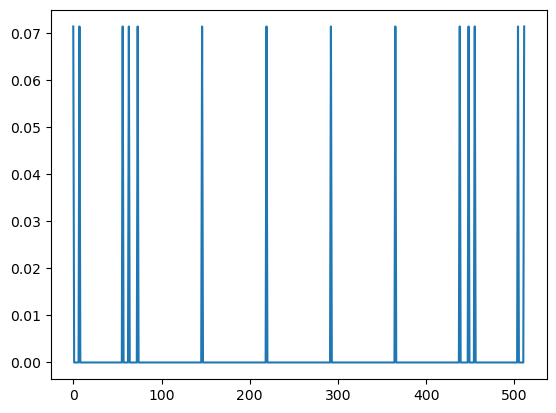

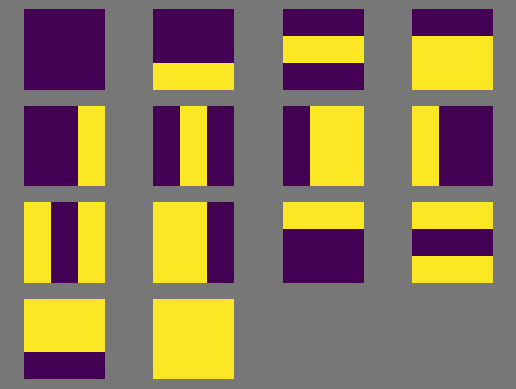

In [26]:
geometry = (3,3)
pl2 = barstripe_pdf(geometry)
plt.plot(pl2)

basis = binary_basis(geometry)

# generate samples
samples = basis[pl2>1e-2]

# show bar and stripes
def plot_bs(samples, size):
    plt.figure(facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i*size[1]+j == len(samples): break
            plt.subplot(gs[i,j]).imshow(samples[i*size[1]+j], vmin=0, vmax=1)
            plt.axis('equal')
            plt.axis('off')
    plt.show()

size = (4, 4)
plot_bs(samples, size)

In [27]:
samples = np.random.multivariate_normal(np.array([0., 0.]), np.eye(2), 14)
data = jax.device_put(samples)

In [28]:
output_folder = "experiment_bars"
os.makedirs(output_folder, exist_ok=True)

In [33]:
h_step_size = 0.1
stochastic_flag = True
qubit = 9
depth = 4
n_qubits = 9
circuit_depth = 4
beta = 100
alpha = 0
n_steps = 20000
batch_size = 200
mu_inv = 10
sigma_a =0.01 

random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)
init_rad = 0.001 / jnp.pi


sgadl_hyperparams = {
    'h': h_step_size, 'M': None, 'mu_inv': mu_inv, 'N_d': 1., 'beta': beta, 'sigma': 1., 'sigma_a': sigma_a,
    'n_steps': n_steps, 'n_qubits': qubit, 'circuit_depth': None, 'batch_size': batch_size
}

gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
data_probs = jnp.ones(len(data)) / len(data)

if stochastic_flag:
    param_to_mmd_and_grad = jit(value_and_grad(lambda param: param_to_mmd_stochastic(param, param_to_st, batch_size)))
else:
    param_to_mmd_and_grad = jit(value_and_grad(lambda param: param_to_mmd(param, param_to_st)))

train_keys = random.split(train_key, sgadl_hyperparams['n_steps'] - 1)

init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
)

# Update hyperparameters with the current n_qubits and circuit_depth
sgadl_hyperparams['M'] = jnp.eye(n_params)

# Run SGADA model
sgada_output, sgada_p_traj, sgada_xi_traj, sgada_cost_vals, sgada_total_run_time = run_simulation_SGAdL(
    alpha, init_param, np.random.randn(n_params), 0.0, ld_BADODAB, (lambda q: -param_to_mmd_and_grad(q)[1]), sgadl_hyperparams, train_keys
)

model_SGAdL = {
    'params': sgada_output,
    'cost_vals': sgada_cost_vals,
    'run_time': sgada_total_run_time,
    'p_traj': sgada_p_traj,
    'xi_traj': sgada_xi_traj
}

# Save results to files
filename = f"results_bars.pkl"
filepath = os.path.join(output_folder, filename)

results = {
    'sgadl': model_SGAdL
}

with open(filepath, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {filepath}")

# Plot the cost values
plt.figure()

ValueError: a must be 1-dimensional

In [35]:
data

Array([[-0.80827945, -0.08165947],
       [ 0.20299481,  0.7850147 ],
       [ 1.7888833 , -1.0249983 ],
       [ 0.07977843,  1.0984998 ],
       [ 1.3538333 , -0.61283964],
       [-0.8860874 , -0.5776437 ],
       [-0.26920363,  0.9387364 ],
       [-1.2815384 ,  0.38446417],
       [ 1.2181135 ,  0.04253144],
       [ 0.9594139 ,  0.50548065],
       [ 0.169418  ,  0.93333554],
       [ 0.98994356,  0.49318898],
       [-1.8562008 , -0.49372905],
       [ 0.84034896, -0.2988858 ]], dtype=float32)